In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier as KNN

from src.pipelines import get_wine_pipeline
from src.metrics import get_scores

from configurations.knn_configurations import default_configuration, parameter_grid

In [34]:
dataset_title = "wine"

In [35]:
data = pd.read_pickle(f'../data/raw/{dataset_title}.pkl')

## Uruchomienie KNN

### Bez stratyfikacji

In [36]:
X, y = data.drop(columns=['class']), data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [37]:
pipeline = get_wine_pipeline()
pipeline.steps.append(['clf', KNN()])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

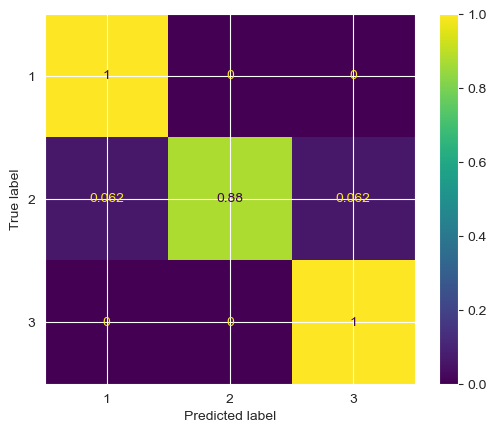

In [38]:
cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
_ = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=pipeline.classes_,
).plot()
plt.savefig(f'../figures/{dataset_title}_cm.png')

In [39]:
get_scores(y_test, y_pred)

{'accuracy': 0.9444, 'precision': 0.9373, 'recall': 0.9583, 'f1': 0.9448}

### Z stratyfikacją

In [40]:
X, y = data.drop(columns=['class']), data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [41]:
pipeline = get_wine_pipeline()
pipeline.steps.append(['clf', KNN()])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

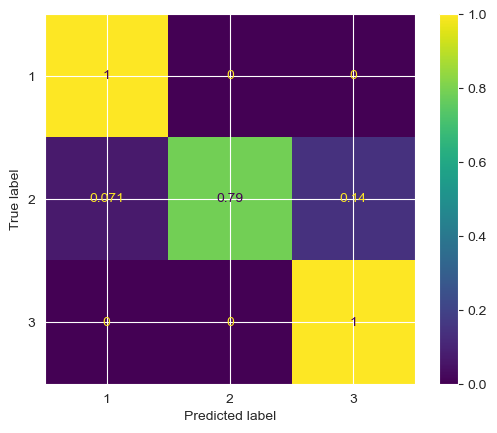

In [42]:
cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
_ = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=pipeline.classes_,
).plot()
plt.savefig(f'../figures/{dataset_title}_cm.png')

In [43]:
get_scores(y_test, y_pred)

{'accuracy': 0.9167, 'precision': 0.9188, 'recall': 0.9286, 'f1': 0.9164}

## Walidacja krzyżowa

### Bez stratyfikacji

In [44]:
folds = [2, 5, 10]

k_folds_test_log = {}
for k in folds:
    k_folds_test_log[k] = cross_validate(pipeline, X, y, cv=k, scoring='f1_macro')['test_score']

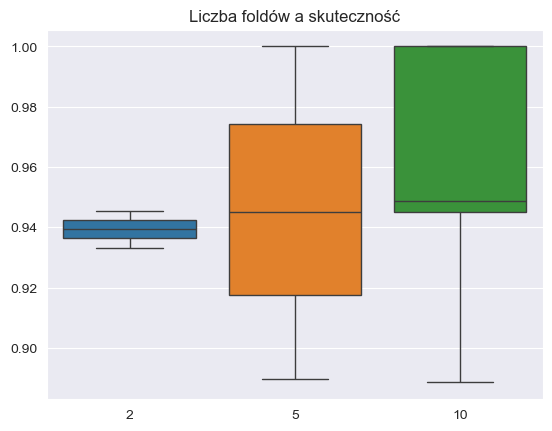

In [45]:
_ = sns.boxplot(k_folds_test_log)
_ = plt.title('Liczba foldów a skuteczność')

### Z stratyfikacją

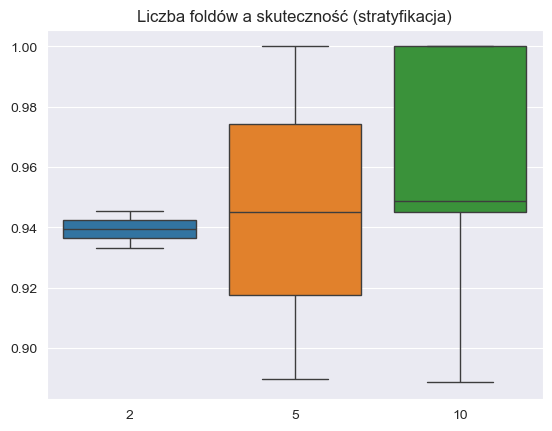

In [46]:
k_folds_test_log_str = {}
for k in folds:
    skf = StratifiedKFold(n_splits=k)
    k_folds_test_log_str[k] = cross_validate(pipeline, X, y, cv=skf, scoring='f1_macro')['test_score']
_ = sns.boxplot(k_folds_test_log_str)
_ = plt.title('Liczba foldów a skuteczność (stratyfikacja)')

## Sprawdzenie różnych wartości parametrów

In [53]:
search = GridSearchCV(pipeline, parameter_grid, cv=5, scoring='f1_macro')
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=0.9,
                                            svd_solver='full')),
                                       ['clf', KNeighborsClassifier()]]),
             param_grid={'clf__metric': ['euclidean', 'manhattan', 'minkowski'],
                         'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15],
                         'clf__weights': ['uniform', 'distance']},
             scoring='f1_macro')

In [54]:
search.best_params_

{'clf__metric': 'euclidean', 'clf__n_neighbors': 15, 'clf__weights': 'uniform'}

In [55]:
grid_search_results = pd.DataFrame(search.cv_results_)

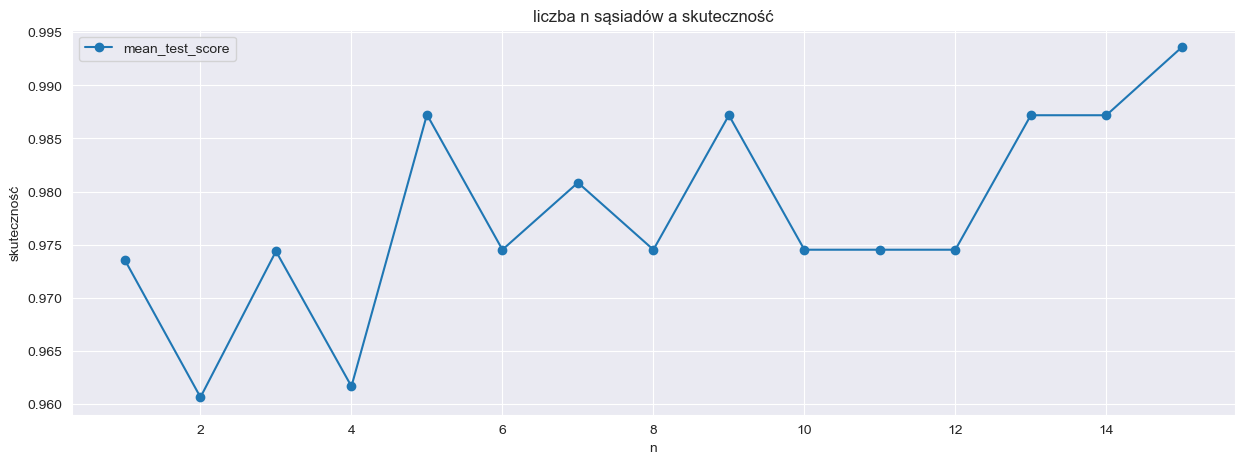

In [56]:
n_neighbors_stats = grid_search_results[(grid_search_results['param_clf__metric'] == default_configuration['clf__metric']) & (grid_search_results['param_clf__weights'] == default_configuration['clf__weights'])]

_ = n_neighbors_stats.plot(
    x='param_clf__n_neighbors',
    y=['mean_test_score'],
    figsize=(15, 5),
    grid=True,
    marker='o',
    xlabel='n',
    ylabel='skuteczność',
    title='liczba n sąsiadów a skuteczność',
)
plt.show()

In [57]:
weights_stats = grid_search_results[(grid_search_results['param_clf__metric'] == default_configuration['clf__metric']) & (grid_search_results['param_clf__n_neighbors'] == default_configuration['clf__n_neighbors'])]

weights_stats[['param_clf__weights', 'mean_test_score', 'std_test_score']]

,param_clf__weights,mean_test_score,std_test_score
68,uniform,0.987243,0.015624
69,distance,0.987243,0.015624


In [58]:
weights_stats = grid_search_results[(grid_search_results['param_clf__weights'] == default_configuration['clf__weights']) & (grid_search_results['param_clf__n_neighbors'] == default_configuration['clf__n_neighbors'])]

weights_stats[['param_clf__metric', 'mean_test_score', 'std_test_score']]

,param_clf__metric,mean_test_score,std_test_score
8,euclidean,0.987243,0.015624
38,manhattan,0.987273,0.025455
68,minkowski,0.987243,0.015624
